**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Aluno:** Gabriel Soares Baptista, 2018102117<br/>

### Questão 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from typing import Tuple

/tmp/ipykernel_10739/2342508658.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Funções auxiliares

In [2]:
def image_plot(image: np.array, size: Tuple[int, int], scaled: bool = False) -> None:
    """ Plota a imagem com as informações passadas """
    plt.figure(figsize=size)
    if not scaled:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()


# Função da primeira lista, apenas para critério de comparação
def convolution_median_filter(image: np.array, order: int) -> np.array:
    """
    Aplica a máscara de mediana pela convolução.
    """
    result = np.zeros(shape=(image.shape))
    M, N = image.shape

    for i in range(0, M - order):
        for j in range(0, N - order):
            result[i, j] = np.median(image[i:i+order, j:j+order].flatten())

    return result


def get_psrn(image: np.array, original: np.array) -> np.float32:
    """
    Calcula o Peak signal-to-noise ratio de uma imagem em
    comparação com a imagem original informada.
    """
    N, M = original.shape
    mse = ((original - image)**2).flatten().sum() / (N * M)
    
    return 10 * np.log10((255**2)/mse)


def compare_images(
    im0: np.array,
    im1: np.array,
    titles: Tuple[str, str] = ('', '')) -> None:
    """
    Plota uma comparação de duas imagens através de um subplot
    contendo ambas imagens informadas. O parâmetro `titles` é
    opcional.
    """
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im0, cmap='gray')
    axs[0].set_title(titles[0])
    axs[1].imshow(im1, cmap='gray')
    axs[1].set_title(titles[1])
    plt.show()


def adaptive_median_filter(
    image: np.array,
    initial_size: int = 1,
    max_size: int = 7) -> np.array:
    """
    Aplica o filtro de mediana adaptativa na imagem informada.
    """
    # Aplica o padding máximo na imagem para que n tenha problemas com
    # bordas independente do tamanho do filtro.
    N, M = image.shape
    enlarged_image = np.pad(image, max_size//2)
    filtered_image = np.zeros(shape=image.shape)

    # Aplica o algoritmo para cada pixel da imagem original,
    # neste caso não estamos incluindo os valores do padding
    for i in tqdm(range(max_size//2, max_size//2 + N)):
        for j in range(max_size//2, max_size//2 + M):
            window_size = initial_size
            stage_b = False

            # define as variáveis utilizadas dentro do estágio A, uma vez que
            # seu último valor será utilizado no estágio B
            window: np.array
            z_min: np.float32
            z_max: np.float32
            z_med: np.float32

            # stage A
            while window_size <= max_size:
                half_size = window_size//2

                # verifica se o tamanho da janela não é unário
                if half_size > 0:
                    window = enlarged_image[i - half_size: i + half_size + 1, j - half_size: j + half_size + 1]
                else:
                    window = enlarged_image[i, j]

                # calcula os valores que serão utilizados
                z_min = np.min(window.flatten())
                z_max = np.max(window.flatten())
                z_med = np.median(window.flatten())
                

                # verifica se irá ou não para o estágio B
                if z_min < z_med < z_max:
                    stage_b = True
                    break # go to stage B
                else:
                    window_size += 2
                    
                    # não irá para o estágio b, retorna z_med
                    if window_size > max_size:
                        break # go to stage B

            # verifica se entra no estágio B ou retorna z_med
            if not stage_b:
                filtered_image[i - max_size//2, j - max_size//2] = z_med
            else:
                # verifica se retorna a intensidade atual ou z_med
                if z_min < enlarged_image[i, j] < z_max:
                    filtered_image[i - max_size//2, j - max_size//2] = enlarged_image[i, j]
                else:
                    filtered_image[i - max_size//2, j - max_size//2] = z_med

    return filtered_image

### Resolução

Primeiro, le-se a imagem original e ruidosa que iremos tentar tratar através do filtro de mediana adaptativa.

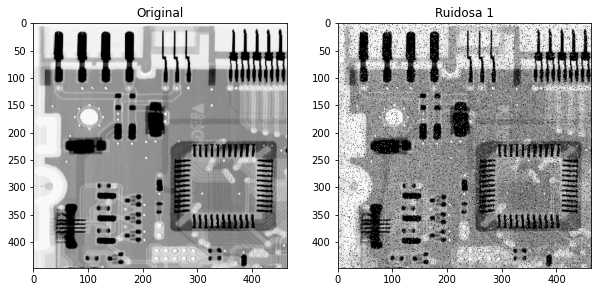

In [3]:
original = plt.imread('../images/original.tif')[:, :, 0].astype('uint8')
ruidosa1 = plt.imread('../images/ruidosa1.tif')
compare_images(original, ruidosa1, ('Original', 'Ruidosa 1'))

Podemos aplicar o filtro definido nas funções auxiliares e observar a diferenteça através da plotagem abaixo.

  0%|          | 0/448 [00:00<?, ?it/s]

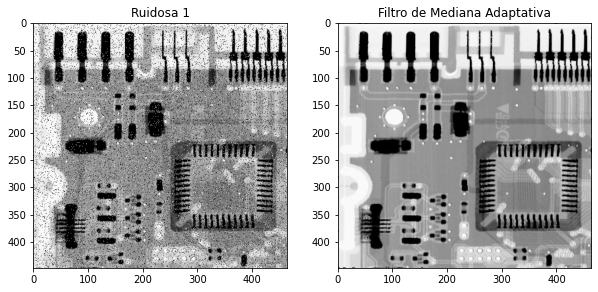

In [4]:
adaptative_median_image1 = adaptive_median_filter(ruidosa1)
compare_images(ruidosa1, adaptative_median_image1, ('Ruidosa 1', 'Filtro de Mediana Adaptativa'))

Podemos observar a mesma melhora drástica para a imagem ruidosa 2.

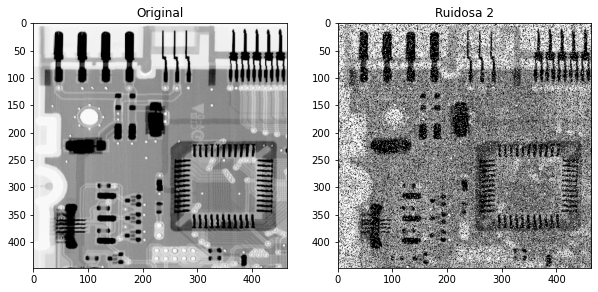

In [5]:
ruidosa2 = plt.imread('../images/ruidosa2.tif')
compare_images(original, ruidosa2, ('Original', 'Ruidosa 2'))

  0%|          | 0/448 [00:00<?, ?it/s]

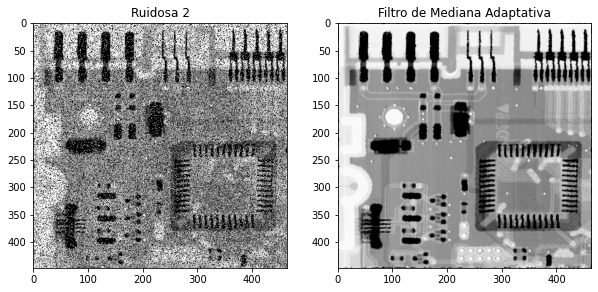

In [6]:
adaptative_median_image2 = adaptive_median_filter(ruidosa2)
compare_images(ruidosa2, adaptative_median_image2, ('Ruidosa 2', 'Filtro de Mediana Adaptativa'))

Agora, fazemos uma comparação com os valores obtidos com as mesmas imagens na lista anterior, entretanto, destaca-se, por questão de coerência, não seria muito benéfico ter em comparação os mesmos filtros, uma vez que o filtro de mediana de tamanho 5x5 foi o melhor, portanto, faremos a comparação tanto com o filtro de mediana de tamanho 5x5 que foi o utilizado quanto com uma janela de tamanho 7x7, uma vez que é o tamanho máximo da janela do filtro adaptativo.

In [7]:
# Aplica os filtros de mediana 5x5 e 7x7 na imagem ruidosa1
median_image1_5x5 = convolution_median_filter(ruidosa1, 5)
median_image1_7x7 = convolution_median_filter(ruidosa1, 7)

# Aplica os filtros de mediana 5x5 e 7x7 na imagem ruidosa2
median_image2_5x5 = convolution_median_filter(ruidosa2, 5)
median_image2_7x7 = convolution_median_filter(ruidosa2, 7)

# Calcula os valores de PSRN para cada imagem
results = pd.DataFrame([
    [
        get_psrn(adaptative_median_image1, original),
        get_psrn(median_image1_5x5, original),
        get_psrn(median_image1_7x7, original),
    ], [
        get_psrn(adaptative_median_image2, original),
        get_psrn(median_image2_5x5, original),
        get_psrn(median_image2_7x7, original),
    ]
], columns=['Mediana 5x5', 'Mediana 7x7', 'Mediana Adaptativa'])

results.index = ['Ruidosa 1', 'Ruidosa 2']

In [8]:
results

,Mediana 5x5,Mediana 7x7,Mediana Adaptativa
Ruidosa 1,30.524953,14.606718,13.120048
Ruidosa 2,22.799862,14.444589,12.992387


Como podemos ver, os filtros de mediana desempenharam muito bem na restauração da imagem. Entretanto, por uma diferença relativamente pequena o filtro de mediana adaptativa teve um melhor desempenho, principalmente quando se comparado com a janela de tamanho 5, mostrando-se que embora o custo computacional seja maior o resultado corresponde a esse aumento de custo.